# Data Preparation for outlier detection
M.J.Madsen
2017-06-07

This notebook steps through the data exploration and preparation for an IoT demo based on batch processing data.

The original data are from this repository https://kuleuven.app.box.com/v/batchbenchmark/4/3864480711. The data were originally published as

Jan Van Impe, Geert Gins, __An extensive reference dataset for fault detection and identification in batch processes__,  
*Chemometrics and Intelligent Laboratory Systems*, Volume 148, 15 November 2015, Pages 20–31.


## Import and explore file structure

The data were orginally in the `HDF5` format. I utilize a python library to read the format and extract the data.

In [2]:
# Loading libraries

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage.interpolation import shift
%matplotlib inline


The measurements available, as described in the original paper, are:

![data](../docs/offline_data.png)

The following features are available "online", i.e. they are automated sensors with readings taken almost continuously. These will be the focus for batch fault detection.

![data](../docs/online_data.png)

I first look at variable names from the base data, a dataset that describes normal batches.

In [3]:
filepath = '../Aligned_set_1_BASE_NOC/Aligned_set_1_BASE_NOC.mat'
f=h5py.File(filepath, 'r')
namedict = {}
for k in range(24):
    st=f["/MeasurementsTags"][0][k]
    obj = f[st]
    str1 = ''.join(chr(i) for i in obj[:])
    print('Var', k, ':', str1 )
    namedict[k] = str1

Var 0 : Time
Var 1 : Fermentation volume
Var 2 : Biomass concentration
Var 3 : Substrate concentration
Var 4 : Penicillin concentration
Var 5 : Dissolved oxygen concentration
Var 6 : Dissolved CO2 concentration
Var 7 : Reactor temperature
Var 8 : pH
Var 9 : Reaction heat
Var 10 : Feed rate
Var 11 : Feed substrate concentration
Var 12 : Feed temperature
Var 13 : Aeration rate
Var 14 : Agitator power
Var 15 : Cooling/heating medium flow rate
Var 16 : Cooling medium temperature
Var 17 : Heating medium temperature
Var 18 : Hot/cold switch
Var 19 : Base flow
Var 20 : Acid flow
Var 21 : Cumulative base flow
Var 22 : Cumulative acid flow
Var 23 : True penicillin concentration


So the variables I want to use (corresponding to online monitoring) are: `[ 1, 5, 6, 7, 8, 10, 12, 14, 15, 21, 22]`

## Data Exploration

I first look at the online variables graphically to get a sense of what they look like. I will use a random sample of 4 of the 400 available datasets. I start by visulaizing the data as a function of batch time.

In [4]:
onlinevars = [0, 1, 5, 6, 7, 8, 10, 12, 14, 15, 21, 22]
subsetSize = 4

# First get normal data
filepath = '../Aligned_set_1_BASE_NOC/Aligned_set_1_BASE_NOC.mat'
g=h5py.File(filepath, 'r')
normalData = g["/Measurements"][:,onlinevars,:]

np.random.seed(1234)
runsToUse = np.sort(np.random.choice(range(normalData.shape[2]),subsetSize))
newnames=np.array(list(namedict.values()))[onlinevars]

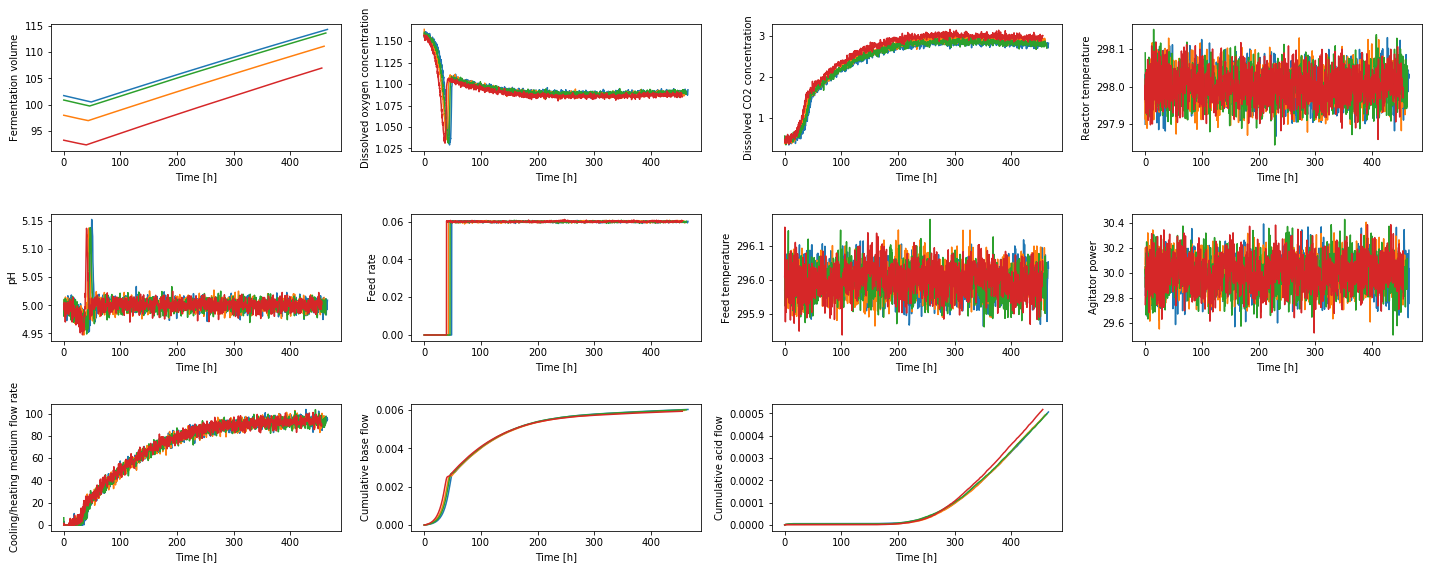

In [6]:

normalSubset = normalData[:,:,runsToUse]

fig = plt.figure(figsize=(20, 8))

for k in range(1,12):

    fig.add_subplot(3,4,k)
    plt.plot(normalSubset[:,0,:],normalSubset[:,k,:])
    plt.xlabel('Time [h]')
    plt.ylabel(newnames[k])

fig.tight_layout()    
fig.savefig('../docs/normaldata.png')


# Sampling Data for IoT

I define a function to enrich each entry in the data: I'll add the prior two measurements (with zeros for the first two readings) to each row. That will give the machine learning algorithm both an idea of the status of the item, as well as an approximation of the first and second derivatives (rate and acceleration).

In [5]:
def enrichMat(m1):
    #yank the first column (time)
    m1withouttime = m1[:,1:,:]
    m1shift1=shift(m1withouttime, [1,0,0], cval=0)
    m1shift2=shift(m1withouttime, [2,0,0], cval=0)

    m1new=np.concatenate((m1,m1shift1,m1shift2),axis=1)
                         
    return m1new



Get 10 runs from the base data for use in IoT project. I do this twice: 

1. I get 10 random runs with all the datapoints in each run (1201 points per run). These are saved in the `data` directory.
2. I get 10 random runs, but with only 10 points per run (randomly chosen). These are saved in the `datasample` directory. This subset is designed to be used when testing the IoT messages - having only 10 points per run makes it easier to test connections and message processing.

## Base case (normal) processing

In [26]:
numRunsPerBase=10

onlineminustime = [1, 5, 6, 7, 8, 10, 12, 14, 15, 21, 22]
colnames = np.squeeze(np.reshape(np.transpose([[namedict[var], namedict[var] + ' prior1',namedict[var] + ' prior2'] for var in onlineminustime]),(1,-1)))
colnames = [namedict[0]] + list(colnames)

newMatsub = newMats[:,:,np.sort(np.random.choice(range(newMats.shape[2]),numRunsPerBase))]
newMatsub = enrichMat(newMats)
for runNum in range(numRunsPerBase):
    newMat = newMatsub[:,:,runNum]
    newMatdf=pd.DataFrame(newMat, columns=colnames)
    newMatdf.to_csv("../data/base1run{0}.csv".format(runNum),index=False)

In [27]:
#Subsampled data (for faster testing)
numRunsPerBase=10
numSamplesPerRun = 10 

newMats = g["/Measurements"][:,onlinevars,:]
newMatsub = newMats[:,:,np.sort(np.random.choice(range(newMats.shape[2]),numRunsPerBase))]
newMatsub = enrichMat(newMats[np.sort(np.random.choice(range(newMats.shape[0]),numSamplesPerRun)),:,:])
for runNum in range(numRunsPerBase):
    newMat = newMatsub[:,:,runNum]
    newMatdf=pd.DataFrame(newMat, columns=colnames)
    newMatdf.to_csv("../datasample/base1run{0}.csv".format(runNum),index=False)

## Fault case processing

Get 10 different random samples from each fault case. We'll use these in our test data.

In [29]:
def getData(faultNums,
            onlinevars,
            numRunsPerFault = 1):
 
    for faultNum in faultNums:
        filepath = '../Aligned_set_1_BASE_fault_{0}/Aligned_set_1_BASE_fault_{0}.mat'.format(faultNum)
        f = h5py.File(filepath, 'r')
        newMats = f["/Measurements"][:,onlinevars,:]
        newMatsub = newMats[:,:,np.sort(np.random.choice(range(newMats.shape[2]),numRunsPerFault))]
        newMatsub = enrichMat(newMats)
        for runNum in range(numRunsPerFault):
            newMat = newMatsub[:,:,runNum]
            newMatdf=pd.DataFrame(newMat, columns=colnames)
            newMatdf.to_csv("../data/fault{0}run{1}.csv".format(faultNum,runNum),index=False)
getData([1,9,11],onlinevars,10)           

Get subsample for faster testing.

In [30]:
numSamplesPerRun = 10 
def getData(faultNums,
            onlinevars = [ 1, 5, 6, 7, 8, 10, 12, 14, 15, 19, 20],
            numRunsPerFault = 1):
 
    for faultNum in faultNums:
        filepath = '../Aligned_set_1_BASE_fault_{0}/Aligned_set_1_BASE_fault_{0}.mat'.format(faultNum)
        f = h5py.File(filepath, 'r')
        newMats = f["/Measurements"][:,onlinevars,:]
        newMatsub = newMats[:,:,np.sort(np.random.choice(range(newMats.shape[2]),numRunsPerFault))]
        newMatsub = enrichMat(newMats[np.sort(np.random.choice(range(newMats.shape[0]),numSamplesPerRun)),:,:])
        for runNum in range(numRunsPerFault):
            newMat = newMatsub[:,:,runNum]
            newMatdf=pd.DataFrame(newMat, columns=colnames)
            newMatdf.to_csv("../datasample/fault{0}run{1}.csv".format(faultNum,runNum),index=False)
getData([1,9,11],onlinevars,10)           